In [1]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import sklearn
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
import keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import os
import re

In [2]:
# split a univariate dataset into train/test sets
def split_dataset(data, n_input, test_length, last_value=None):
    if test_length*n_input >= len(data):
        raise Exception("Test length too big")
    else:
        if last_value is not None:
            data = data[:last_value+1]

        train_end = len(data)-test_length*n_input
        train_start = train_end%n_input
        train, test = data[train_start:train_end], data[train_end:]
        # restructure into windows of weekly data
        train = array(split(train, len(train)/n_input))
        test = array(split(test, len(test)/n_input))
        return train, test

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [4]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [5]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out, samples_step=1):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += samples_step
    return array(X), array(y)

In [36]:
# train the model
def build_model(train, n_input, n_out, samples_step=1):
    # prepare data
    train_x, train_y = to_supervised(train, n_input, n_out, samples_step=samples_step)
    print(train_x.shape)
    # define parameters
    verbose, epochs, batch_size = 1, 30, 32
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(1024, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=True)
    return model

In [7]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [8]:
# evaluate a single model
def evaluate_model(train, test, n_input, n_out, samples_step=1):
    # fit model
    model = build_model(train, n_input, n_out, samples_step=samples_step)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions


In [9]:
# Load files
def load_file(path):
    return read_csv(path, sep=";", header=0, infer_datetime_format=True, parse_dates=['timestamp'], index_col=['timestamp'])

In [10]:
# Define computer paths and filenames
directory = "../data/processed/batiments/"
filename = "3000.csv"

In [11]:
# Load Files
dataset = load_file(directory+filename)

In [13]:
# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
x = array(dataset['active_power'].values)
x = x.reshape((x.shape[0], 1))
scaler.fit(x)
dataset['active_power'] = scaler.transform(x)

(533, 168, 1)
Epoch 1/30
17/17 [==============================] - 44s 2s/step - loss: 0.0140

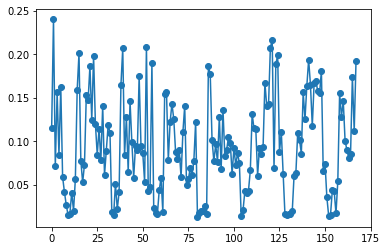

In [37]:
# Run script
time_step = 60 # minutes
n_input = 7*24*60//time_step
n_out = 7*24*60//time_step
n_tests = len(dataset)//n_input//4
samples_step = 24*60//time_step

train, test = split_dataset(dataset, n_input, n_tests)
score, scores, predictions = evaluate_model(train, test, n_input, n_out, samples_step=samples_step)
summarize_scores('lstm', score, scores)

# plot scores
pyplot.plot(scores, marker='o', label='lstm')
pyplot.show()


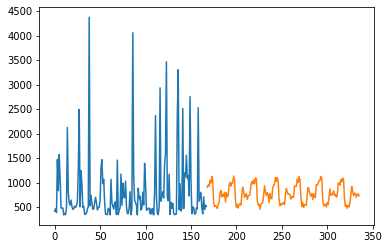

In [38]:
# Show predictions
train_flat = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
pred_flat = predictions.flatten()
train_ = scaler.inverse_transform(np.expand_dims(train_flat[:, 0], axis=1))
pred_ = scaler.inverse_transform(np.expand_dims(pred_flat, axis=1))
last_n = 1
train_length = last_n * train.shape[1]
pred_length = predictions.shape[1]
x1 = list(range(train_length))
y1 = train_[-train_length:]
x2 = list(range(train_length, train_length+pred_length))
y2 = pred_[:pred_length]
pyplot.figure(2)
pyplot.plot(x1, y1, x2, y2)
pyplot.show()